In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5.5
fig_height = 3.5
fig_format = :pdf
fig_dpi = 300

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using CSV, DataFrames
df = CSV.read("datos/tenis.csv", DataFrame)

Row,Cielo,Temperatura,Humedad,Viento,Tenis
,String15,String15,String7,String7,String3
1,Soleado,Caluroso,Alta,Suave,No
2,Soleado,Caluroso,Alta,Fuerte,No
3,Nublado,Caluroso,Alta,Suave,Sí
4,Lluvioso,Moderado,Alta,Suave,Sí
5,Lluvioso,Frío,Normal,Suave,Sí
6,Lluvioso,Frío,Normal,Fuerte,No
7,Nublado,Frío,Normal,Fuerte,Sí
8,Soleado,Moderado,Alta,Suave,No
9,Soleado,Frío,Normal,Suave,Sí


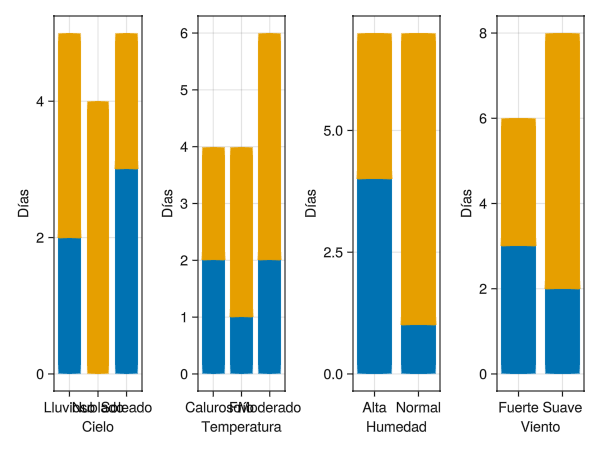

In [3]:
using GLMakie, AlgebraOfGraphics

function frecuencias(df::DataFrame, var::Symbol)
    # Calculamos el número de días de cada clase que se juega al tenis.
    frec = combine(groupby(df, [var, :Tenis]), nrow => :Días)
    # Dibujamos el diagrama de barras.
    plt = data(frec) * 
    mapping(var, :Días, stack = :Tenis, color = :Tenis, ) * 
    visual(BarPlot) 
    # Devolvemos el gráfico.
    return plt
end

fig = Figure()
draw!(fig[1, 1], frecuencias(df, :Cielo))
draw!(fig[1, 2], frecuencias(df, :Temperatura))
draw!(fig[1, 3], frecuencias(df, :Humedad))
draw!(fig[1, 4], frecuencias(df, :Viento))
fig

In [4]:
function gini(df::DataFrame, var::Symbol)
    # Calculamos el número de ejemplos.
    n = nrow(df)
    # Calculamos las frecuencias absolutas de cada clase.
    frec = combine(groupby(df, var), nrow => :ni)
    # Calculamos la proporción de cada clase.
    frec.p = frec.ni ./ n
    # Calculamos el índice de Gini.
    gini = 1 - sum(frec.p .^ 2)
    return gini
end

g0 = gini(df, :Tenis)

0.4591836734693877

In [5]:
using Tidier
# Dividimos el conjunto de ejemplos según la variable Humedad.
df_humedad_alta = @filter(df, Humedad == "Alta")
df_humedad_normal = @filter(df, Humedad == "Normal")
# Calculamos los tamaños de los subconjuntos de ejemplos.
n = nrow(df_humedad_alta), nrow(df_humedad_normal)
# Calculamos el índice de Gini de cada subconjunto.
gis = gini(df_humedad_alta, :Tenis), gini(df_humedad_normal, :Tenis)
# Calculamos media ponderada de los índices de Gini de los subconjuntos 
g_humedad = sum(gis .* n) / sum(n)
# Calculamos la reducción del índice de Gini.
g0 - g_humedad

0.09183673469387743

In [6]:
# Dividimos el conjunto de ejemplos según la variable `Viento`
df_viento_fuerte = @filter(df, Viento == "Fuerte")
df_viento_suave = @filter(df, Viento == "Suave")
# Calculamos los tamaños de los subconjuntos de ejemplos
n = nrow(df_viento_fuerte), nrow(df_viento_suave)
# Calculamos el índice de Gini de cada subconjunto
gis = gini(df_viento_fuerte, :Tenis), gini(df_viento_suave, :Tenis)
# Calculamos media ponderada de los índices de Gini de los subconjuntos
g_viento = sum(gis .* n) / sum(n)
# Calculamos la reducción del índice de Gini
g0 - g_viento

0.030612244897959162

In [7]:
using DecisionTree, CategoricalArrays
# Variables predictoras.
X = Matrix(select(df, Not(:Tenis)))
# Variable objetivo.
y = df.Tenis
# Convertir las variables categóricas a enteros.
X = hcat([levelcode.(categorical(X[:, j])) for j in 1:size(X, 2)]...)
# Convertir la variable objetivo a enteros.
y = levelcode.(categorical(y))
tree = DecisionTreeClassifier(max_depth=3)
fit!(tree, X, y)

DecisionTreeClassifier
max_depth:                3
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  [1, 2]
root:                     Decision Tree
Leaves: 6
Depth:  3

In [8]:
print_tree(tree, feature_names=names(df)[1:end-1])

Feature 3: "Humedad" < 2.0 ?


├─ Feature 1: "Cielo" < 3.0 ?
    ├─ Feature 4: "Viento" < 2.0 ?
        ├─ 2 : 1/2
        └─ 2 : 2/2
    └─ 1 : 3/3
└─ Feature 1: "Cielo" < 2.0 ?
    ├─ Feature 4: "Viento" < 2.0 ?
        ├─ 1 : 1/1
        └─ 2 : 2/2
    └─ 2 : 4/4


In [9]:
using CSV, DataFrames
df = CSV.read("datos/pingüinos.csv", DataFrame, missingstring="NA")

Row,Especie,Isla,Longitud_pico,Profundidad_pico,Longitud_ala,Peso,Sexo
,String15,String15,Float64?,Float64?,Int64?,Int64?,String7?
1,Adelie,Torgersen,39.1,18.7,181,3750,macho
2,Adelie,Torgersen,39.5,17.4,186,3800,hembra
3,Adelie,Torgersen,40.3,18.0,195,3250,hembra
4,Adelie,Torgersen,missing,missing,missing,missing,missing
5,Adelie,Torgersen,36.7,19.3,193,3450,hembra
6,Adelie,Torgersen,39.3,20.6,190,3650,macho
7,Adelie,Torgersen,38.9,17.8,181,3625,hembra
8,Adelie,Torgersen,39.2,19.6,195,4675,macho
9,Adelie,Torgersen,34.1,18.1,193,3475,missing


In [10]:
describe(df, :nmissing)

Row,variable,nmissing
,Symbol,Int64
1,Especie,0
2,Isla,0
3,Longitud_pico,2
4,Profundidad_pico,2
5,Longitud_ala,2
6,Peso,2
7,Sexo,11


In [11]:
dropmissing!(df)

Row,Especie,Isla,Longitud_pico,Profundidad_pico,Longitud_ala,Peso,Sexo
,String15,String15,Float64,Float64,Int64,Int64,String7
1,Adelie,Torgersen,39.1,18.7,181,3750,macho
2,Adelie,Torgersen,39.5,17.4,186,3800,hembra
3,Adelie,Torgersen,40.3,18.0,195,3250,hembra
4,Adelie,Torgersen,36.7,19.3,193,3450,hembra
5,Adelie,Torgersen,39.3,20.6,190,3650,macho
6,Adelie,Torgersen,38.9,17.8,181,3625,hembra
7,Adelie,Torgersen,39.2,19.6,195,4675,macho
8,Adelie,Torgersen,41.1,17.6,182,3200,hembra
9,Adelie,Torgersen,38.6,21.2,191,3800,macho


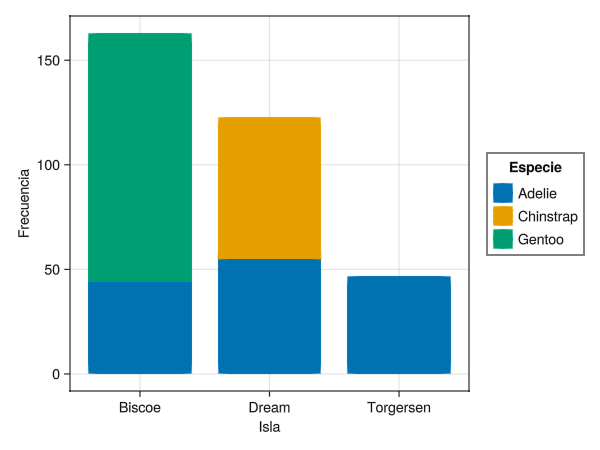

In [12]:
using GLMakie, AlgebraOfGraphics

frec_isla = combine(groupby(df, [:Isla, :Especie]), nrow => :Frecuencia)
data(frec_isla) * 
    mapping(:Isla, :Frecuencia, stack = :Especie, color =:Especie) *
    visual(BarPlot) |> draw

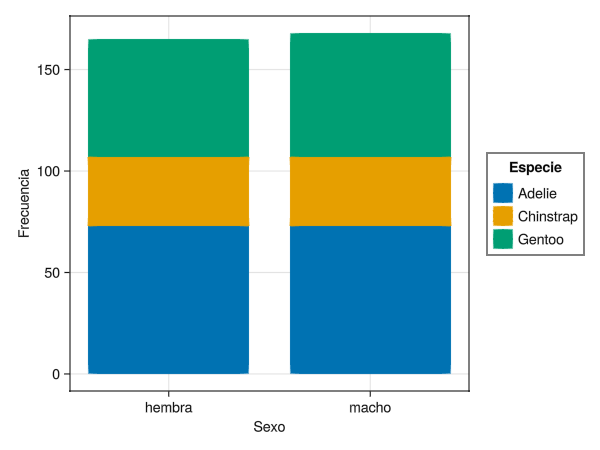

In [13]:
frec_sexo = combine(groupby(df, [:Sexo, :Especie]), nrow => :Frecuencia)
data(frec_sexo) * 
    mapping(:Sexo, :Frecuencia, stack = :Especie, color =:Especie) *
    visual(BarPlot) |> draw

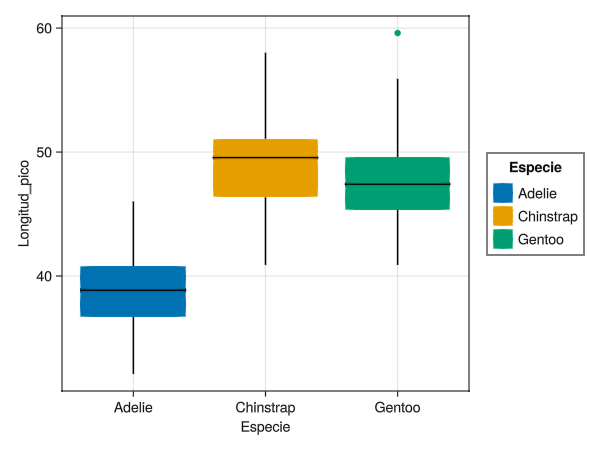

In [14]:
function cajas(df, var, clase)
    data(df) *
        mapping(clase, var, color = clase) *
        visual(BoxPlot) |> 
        draw
end

cajas(df, :Longitud_pico, :Especie)

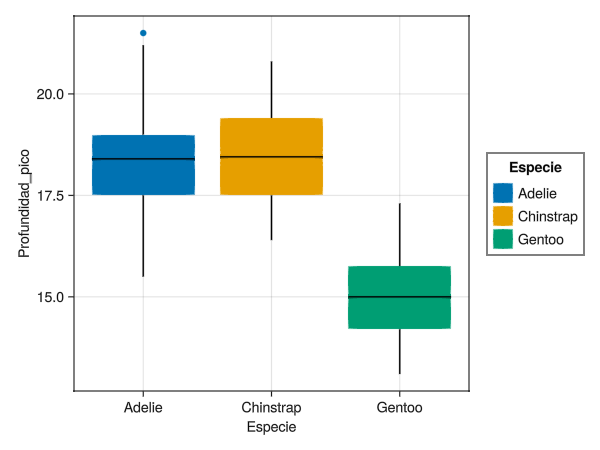

In [15]:
cajas(df, :Profundidad_pico, :Especie)

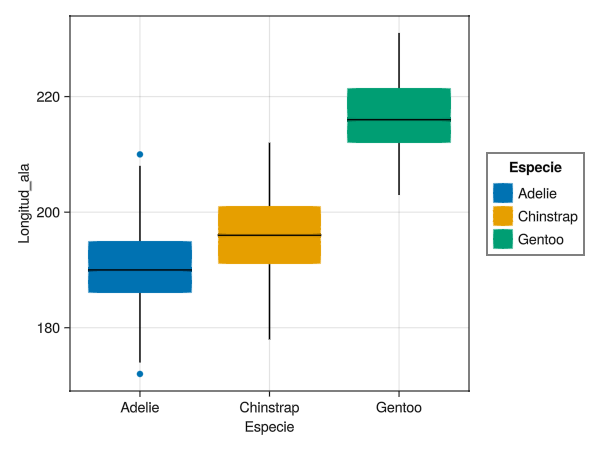

In [16]:
cajas(df, :Longitud_ala, :Especie)

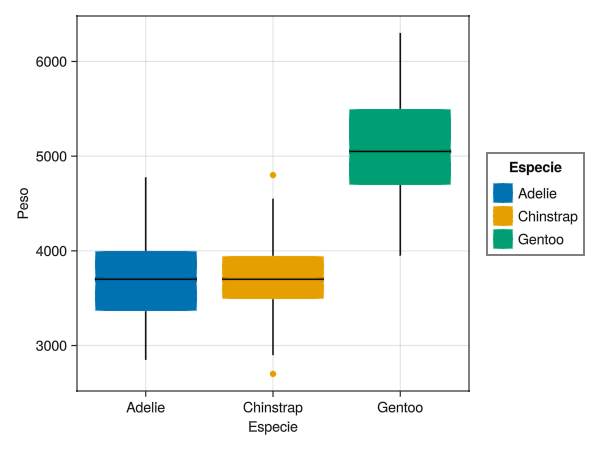

In [17]:
cajas(df, :Peso, :Especie)

In [18]:
using Tidier
function gini(df::DataFrame, var::Symbol)
    n = nrow(df)
    frec = combine(groupby(df, var), nrow => :ni)
    frec.p = frec.ni ./ n
    gini = 1 - sum(frec.p .^ 2)
    return gini
end

function reduccion_impureza(df::DataFrame, var::Symbol, val::Number)
    # Dividimos el conjunto de ejemplos según la longitud del pico es menor de 44.
    df_menor = @eval @filter($df, $var <= $val)
    df_mayor = @eval @filter($df, $var > $val)
    # Calculamos los tamaños de los subconjuntos de ejemplos.
    n = nrow(df_menor), nrow(df_mayor)
    # Calculamos el índice de Gini de cada subconjunto.
    gis = gini(df_menor, :Especie), gini(df_mayor, :Especie)
    # Calculamos media ponderada de los índices de Gini de los subconjuntos.
    g1 = sum(gis .* n) / sum(n)
    # Calculamos la reducción del índice de Gini.
    gini(df, :Especie) - g1
end

reduccion_impureza(df, :Longitud_pico, 44)

0.26577182779353914

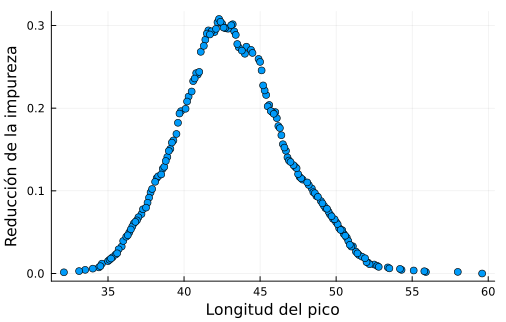

In [19]:
using Plots
# Valores únicos de longitud del pico.
valores = unique(df.Longitud_pico)
# Reducción de la impureza para cada valor.
reducciones = [reduccion_impureza(df, :Longitud_pico, val) for val in valores]
# Graficamos el resultado.
Plots.scatter(valores, reducciones, xlabel = "Longitud del pico", ylabel = "Reducción de la impureza", legend = false)

In [20]:
val_optimo = valores[argmax(reducciones)]

42.3

In [21]:
using Random
# Establecemos la semilla para la reproducibilidad.
Random.seed!(1234)
# Barajamos el dataframe.
df = shuffle(df)
# Dividimos el dataframe en un conjunto de entrenamiento y un conjunto de test.
n = nrow(df)
df_test = df[1:div(n, 4), :]
df_train = df[div(n, 4)+1:end, :]

Row,Especie,Isla,Longitud_pico,Profundidad_pico,Longitud_ala,Peso,Sexo
,String15,String15,Float64,Float64,Int64,Int64,String7
1,Adelie,Dream,39.0,18.7,185,3650,macho
2,Chinstrap,Dream,52.8,20.0,205,4550,macho
3,Chinstrap,Dream,55.8,19.8,207,4000,macho
4,Adelie,Torgersen,35.1,19.4,193,4200,macho
5,Adelie,Torgersen,34.6,21.1,198,4400,macho
6,Gentoo,Biscoe,50.0,15.2,218,5700,macho
7,Chinstrap,Dream,50.6,19.4,193,3800,macho
8,Chinstrap,Dream,43.5,18.1,202,3400,hembra
9,Adelie,Dream,36.9,18.6,189,3500,hembra


In [22]:
using DecisionTree, CategoricalArrays
# Variables predictivas.
X_train = Matrix(select(df_train, Not(:Isla, :Especie)))
# Variable objetivo.
y_train = df_train.Especie
# Convertir las variables categóricas a enteros.
X_train = hcat([levelcode.(categorical(X_train[:, j])) for j in 1:size(X_train, 2)]...)
# Convertir la variable objetivo a enteros
y_train = levelcode.(categorical(y_train))

# Construimos el árbol de decisión con profundidad máxima 3.
tree = DecisionTreeClassifier(max_depth = 3)
fit!(tree, X_train, y_train)
print_tree(tree, feature_names=names(df)[3:end])

Feature 3: "Longitud_ala" < 29.0 ?


├─ Feature 1: "Longitud_pico" < 62.0 ?
    ├─ 1 : 96/96
    └─ Feature 1: "Longitud_pico" < 87.0 ?
        ├─ 2 : 10/20
        └─ 2 : 37/38
└─ Feature 2: "Profundidad_pico" < 46.0 ?
    ├─ 3 : 90/90
    └─ Feature 1: "Longitud_pico" < 109.0 ?
        ├─ 1 : 2/2
        └─ 2 : 4/4


In [23]:
using StatisticalMeasures
# Variables predictivas
X_test = Matrix(select(df_test, Not(:Isla, :Especie)))
# Variable objetivo
y_test = df_test.Especie
# Convertir las variables categóricas a enteros
X_test = hcat([levelcode.(categorical(X_test[:, j])) for j in 1:size(X_test, 2)]...)
# Convertir la variable objetivo a enteros
y_test = levelcode.(categorical(y_test))
# Predecimos la especie de pingüino del conjunto de test
y_pred = predict(tree, X_test)
# Calculamos la precisión del modelo
confmat(y_pred, y_test)

          ┌──────────────┐
          │ Ground Truth │
┌─────────┼────┬────┬────┤
│Predicted│ 1  │ 2  │ 3  │
├─────────┼────┼────┼────┤
│    1    │ 38 │ 11 │ 9  │
├─────────┼────┼────┼────┤
│    2    │ 0  │ 6  │ 0  │
├─────────┼────┼────┼────┤
│    3    │ 0  │ 0  │ 19 │
└─────────┴────┴────┴────┘


In [24]:
# Calculamos la precisión del modelo
accuracy(y_pred, y_test)

0.7590361445783133

In [25]:
using CSV, DataFrames
df = CSV.read("datos/vinos.csv", DataFrame)

Row,tipo,meses_barrica,acided_fija,acided_volatil,acido_citrico,azucar_residual,cloruro_sodico,dioxido_azufre_libre,dioxido_azufre_total,densidad,ph,sulfatos,alcohol,calidad
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,blanco,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
2,blanco,0,6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6
3,blanco,0,8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6
4,blanco,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6
5,blanco,0,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
6,blanco,0,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6
7,blanco,0,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0,5
8,blanco,0,8.6,0.23,0.4,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,5
9,blanco,0,7.9,0.18,0.37,1.2,0.04,16.0,75.0,0.992,3.18,0.63,10.8,5


In [26]:
using MLJ
schema(df)

┌──────────────────────┬────────────┬─────────┐
│ names                │ scitypes   │ types   │
├──────────────────────┼────────────┼─────────┤
│ tipo                 │ Textual    │ String7 │
│ meses_barrica        │ Count      │ Int64   │
│ acided_fija          │ Continuous │ Float64 │
│ acided_volatil       │ Continuous │ Float64 │
│ acido_citrico        │ Continuous │ Float64 │
│ azucar_residual      │ Continuous │ Float64 │
│ cloruro_sodico       │ Continuous │ Float64 │
│ dioxido_azufre_libre │ Continuous │ Float64 │
│ dioxido_azufre_total │ Continuous │ Float64 │
│ densidad             │ Continuous │ Float64 │
│ ph                   │ Continuous │ Float64 │
│ sulfatos             │ Continuous │ Float64 │
│ alcohol              │ Continuous │ Float64 │
│ calidad              │ Count      │ Int64   │
└──────────────────────┴────────────┴─────────┘


In [27]:
describe(df, :nmissing)

Row,variable,nmissing
,Symbol,Int64
1,tipo,0
2,meses_barrica,0
3,acided_fija,0
4,acided_volatil,0
5,acido_citrico,0
6,azucar_residual,0
7,cloruro_sodico,0
8,dioxido_azufre_libre,0
9,dioxido_azufre_total,0


In [28]:
using CategoricalArrays
# Recodificamos la variable calidad.
df.calidad = cut(df.calidad, [0, 6.5, 10], labels = [0, 1])

5320-element CategoricalArray{Int64,1,UInt32}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 1
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [29]:
y, X = unpack(df, ==(:calidad), rng = 123)

(CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 5320×13 DataFrame
  Row │ tipo     meses_barrica  acided_fija  acided_volatil  acido_citrico  az ⋯
      │ String7  Int64          Float64      Float64         Float64        Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ blanco               0          6.7           0.5             0.36     ⋯
    2 │ blanco               0          6.3           0.2             0.3
    3 │ blanco               0          6.2           0.35            0.03
    4 │ tinto                3          8.0           0.39            0.3
    5 │ blanco               0          7.9           0.255           0.26     ⋯
    6 │ blanco               0          6.1           0.31            0.37
    7 │ blanco               0          6.8           0.28            0.36
    8 │ blanco               0          8.2           0.34            0.49
    9 │ tinto                0  

In [30]:
# Convertir las variables categóricas a enteros.
coerce!(X, :tipo => OrderedFactor, :meses_barrica => Continuous)
schema(X)

┌──────────────────────┬──────────────────┬───────────────────────────────────┐
│ names                │ scitypes         │ types                             │
├──────────────────────┼──────────────────┼───────────────────────────────────┤
│ tipo                 │ OrderedFactor{2} │ CategoricalValue{String7, UInt32} │
│ meses_barrica        │ Continuous       │ Float64                           │
│ acided_fija          │ Continuous       │ Float64                           │
│ acided_volatil       │ Continuous       │ Float64                           │
│ acido_citrico        │ Continuous       │ Float64                           │
│ azucar_residual      │ Continuous       │ Float64                           │
│ cloruro_sodico       │ Continuous       │ Float64                           │
│ dioxido_azufre_libre │ Continuous       │ Float64                           │
│ dioxido_azufre_total │ Continuous       │ Float64                           │
│ densidad             │ Continuous     

In [31]:
Tree = @iload DecisionTreeClassifier pkg = "DecisionTree"
tree = Tree(max_depth = 3, rng = 123)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJDecisionTreeInterface ✔


DecisionTreeClassifier(
  max_depth = 3, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = 123)

In [32]:
evaluate(tree, X, y, resampling = StratifiedCV(shuffle=true), measures=[cross_entropy, confusion_matrix, true_positive_rate, true_negative_rate, ppv, npv, accuracy])

Evaluating over 6 folds:  33%[========>                ]  ETA: 0:00:09

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬──────────────────────────┬──────────────┬─────────────────────────────────
│   │ measure                  │ operation    │ measurement                    ⋯
├───┼──────────────────────────┼──────────────┼─────────────────────────────────
│ A │ LogLoss(                 │ predict      │ 0.376                          ⋯
│   │   tol = 2.22045e-16)     │              │                                ⋯
│ B │ ConfusionMatrix(         │ predict_mode │ ConfusionMatrix{2}([3819762 77 ⋯
│   │   levels = nothing,      │              │                                ⋯
│   │   perm = nothing,        │              │                                ⋯
│   │   rev = nothing,         │              │                                ⋯
│   │   checks = true)         │              │              